In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from ultron.factor.fitness.metrics import Metrics
from ultron.factor.fitness.state import State

In [3]:
import pandas as pd

In [4]:
from kdutils.data import fetch_base

In [5]:
base = '/mnt/nass125/data/basic_data/dx_data/dubhe'

In [19]:
path1 = 'liaison0004_2p_3s_ranking_state_dubhe_hs300_1'
dirs = os.path.join(base, os.environ['DUMMY_NAME'], 'MAE1', 
            path1)

In [20]:
filename = os.path.join(dirs, "liaison0004_factors_1.feather")
factors_data = pd.read_feather(filename)

In [21]:
begin_date = factors_data['trade_time'].min().strftime('%Y-%m-%d')
end_date = factors_data['trade_time'].max().strftime('%Y-%m-%d')

In [22]:
remain_data = fetch_base(begin_date, end_date)
ret_data = remain_data['ret_f1r_cc']
dummy120_fst = remain_data['dummy120_fst']
dummy120_fst_close = remain_data['dummy120_fst_close']
hs300 = remain_data['hs300']
zz1000 = remain_data['zz1000']
zz500 = remain_data['zz500']

2024-12-16 16:34:29,001 - kd - INFO - fetching load ret_f1r_cc data
2024-12-16 16:34:29,006 - kd - INFO - sql:select ret_f1r_cc,trade_date,code from loadTable('dfs://StkRet',`stk_ret) where 1==1 and date(trade_date)>= 2023.05.16 and date(trade_date)<= 2024.09.09 and Flag= 1
2024-12-16 16:34:34,818 - kd - INFO - fetching load dummy120_fst data
2024-12-16 16:34:34,826 - kd - INFO - sql:select dummy120_fst,trade_date,code from loadTable('dfs://StkUniverse',`stk_universe) where 1==1 and date(trade_date)>= 2023.05.16 and date(trade_date)<= 2024.09.09 and Flag= 1
2024-12-16 16:34:37,916 - kd - INFO - fetching load dummy120_fst_close data
2024-12-16 16:34:37,923 - kd - INFO - sql:select dummy120_fst_close,trade_date,code from loadTable('dfs://StkUniverse',`stk_universe) where 1==1 and date(trade_date)>= 2023.05.16 and date(trade_date)<= 2024.09.09 and Flag= 1
2024-12-16 16:34:41,157 - kd - INFO - fetching load hs300 data
2024-12-16 16:34:41,164 - kd - INFO - sql:select hs300,trade_date,code f

In [23]:
yields_data = ret_data.reindex(dummy120_fst.index, columns=dummy120_fst.columns)
#yields_data = yields_data[(hs300 == 1) | (zz500 == 1) | (zz1000 == 1)] * dummy120_fst_close * dummy120_fst
yields_data = yields_data[(hs300 == 1) ] * dummy120_fst_close * dummy120_fst
dummy_fst = dummy120_fst_close * dummy120_fst
factors_data = factors_data.set_index(['trade_time', 'code'])
factor_columns = factors_data.columns

In [24]:
cols = ['factor_0','factor_1','factor_2','factor_3','factor_4']

In [25]:
def f1(col):
    factors_data0 = factors_data[col].copy()
    factors_data0 = factors_data0.unstack()
    factors_data0 = factors_data0.reindex(dummy120_fst.index, columns=dummy120_fst.columns)
#factors_data0 = factors_data0[(hs300 == 1) | (zz500 == 1) | (zz1000 == 1)] * dummy_fst
    factors_data0 = factors_data0[(hs300 == 1)] * dummy_fst
    yields_data0 = yields_data.reindex(factors_data0.index,
                                           columns=factors_data0.columns)
    dummy_fst0 = dummy_fst.reindex(factors_data0.index,
                                       columns=factors_data0.columns)
    results = Metrics.general(factors=factors_data0,
                              returns=yields_data0,
                              dummy=dummy_fst0,
                              hold=1,
                              is_series=True)
    return results

In [26]:
ft0 = f1('factor_0').long_evaluate
ft1 = f1('factor_1').long_evaluate
ft2 = f1('factor_2').long_evaluate
ft3 = f1('factor_3').long_evaluate
ft4 = f1('factor_4').long_evaluate

factor fit metrics::100.0%

In [27]:
def trans(f0, name):
    return {
        'name':name,
        'sharp':f0.sharp,
        'returns_mean':f0.returns_mean,
        'returns_std':f0.returns_std,
        'returns_mdd':f0.returns_mdd,
        'fitness':f0.fitness,
        'turnover':f0.turnover,
        'maxdd':f0.maxdd
    }

In [28]:
pd.DataFrame(
    [
        trans(ft0, 'factor_0'),
        trans(ft1, 'factor_1'),
        trans(ft2, 'factor_2'),
        trans(ft3, 'factor_3'),
        trans(ft4, 'factor_4'),
    ]
)

,name,sharp,returns_mean,returns_std,returns_mdd,fitness,turnover,maxdd
0,factor_0,0.494909,0.015934,0.032196,0.625102,-0.696829,0.076739,0.025491
1,factor_1,1.718514,0.060008,0.034918,2.627341,0.579232,0.079564,0.022840
2,factor_2,1.335245,0.055254,0.041381,1.701028,0.446336,0.073568,0.032482
3,factor_3,1.946358,0.070195,0.036065,2.505465,0.749949,0.086297,0.028017
4,factor_4,0.720904,0.023439,0.032513,0.905093,-0.485838,0.078470,0.025897


In [29]:
def ser(f0, name):
    f1 = f0.returns_series
    f1.name = name
    return f1

<Axes: xlabel='trade_date'>

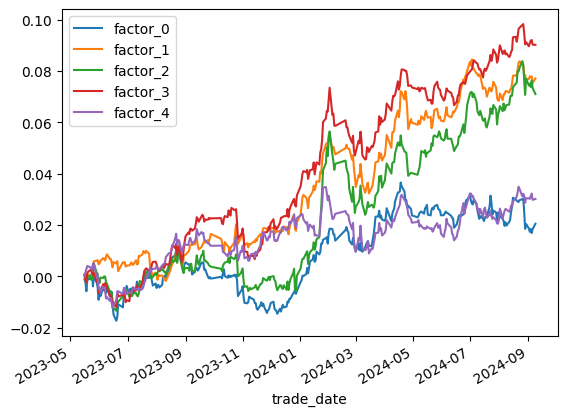

In [30]:
pd.DataFrame(
    [
        ser(ft0, 'factor_0'),
        ser(ft1, 'factor_1'),
        ser(ft2, 'factor_2'),
        ser(ft3, 'factor_3'),
        ser(ft4, 'factor_4'),
    ]
).T.cumsum().plot()